## What? Where? Why?

In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import gc
import pickle
from tqdm import tqdm

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')

### Background
В спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно `36` или `45`, иногда `60`, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:

1. построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
2. при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому **единицей рейтинг-листа** должна быть не команда, а **отдельный игрок**;
3. а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        unpickled = pickle.load(file)
    return unpickled


def dump_pickle(to_pickle, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(to_pickle, file)

### Часть 1.

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле `mask` в `results.pkl`). Для унификации предлагаю:
- взять в тренировочный набор турниры с `dateStart` из 2019 года;
- в тестовый — турниры с `dateStart` из 2020 года.

### Подготовка данных
Если уже подготовлены - перейти сразу к загрузке!

In [5]:
%%time
players = load_pickle("data/players.pkl")
results = load_pickle("data/results.pkl")
print()


CPU times: user 9.67 s, sys: 17 s, total: 26.7 s
Wall time: 34.8 s


In [6]:
random_player = 11
print(f"Player #{random_player} example:")
players[random_player]

Player #11 example:


{'id': 11, 'name': 'Наталья', 'patronymic': 'Юрьевна', 'surname': 'Абалымова'}

In [7]:
tournaments = load_pickle("data/tournaments.pkl")
# to take a look on data
random_tournament = random.randint(1, len(tournaments)) # random tournament data: dict[str: value]

In [8]:
print(f"{len(tournaments)} tournaments", end='\n\n')
print(f"Tournament #{random_tournament} data:")
print(*list(tournaments[random_tournament].items()), sep='\n', end='\n\n')
print("Results example:")
print(*list(results[random_tournament][0].items()), sep='\n')

5528 tournaments

Tournament #3981 data:
('id', 3981)
('name', 'Кубок весей. Онлайн')
('dateStart', '2016-12-24T12:40:00+03:00')
('dateEnd', '2016-12-24T16:00:00+03:00')
('type', {'id': 6, 'name': 'Строго синхронный'})
('season', '/seasons/50')
('orgcommittee', [{'id': 29613, 'name': 'Дмитрий', 'patronymic': 'Борисович', 'surname': 'Смирнов'}])
('synchData', {'dateRequestsAllowedTo': '2016-12-23T23:59:59+03:00', 'resultFixesTo': '2017-01-01T23:59:59+03:00', 'resultsRecapsTo': '2016-12-25T23:59:59+03:00', 'allowAppealCancel': True, 'allowNarratorErrorAppeal': False, 'dateArchivedAt': '2017-01-14T23:59:59+03:00', 'dateDownloadQuestionsFrom': '2016-12-23T00:00:00+03:00', 'dateDownloadQuestionsTo': '2016-12-24T13:00:00+03:00', 'hideQuestionsTo': '2016-12-29T23:59:59+03:00', 'hideResultsTo': '2016-12-29T23:59:59+03:00', 'allVerdictsDone': None, 'instantControversial': True})
('questionQty', {'1': 12, '2': 12, '3': 12})

Results example:
('team', {'id': 312, 'name': 'Социал-демократы', 'town

In [9]:
TRAIN_START_YEAR = "2019"
TEST_START_YEAR = "2020"


def tournament_in_group(tournament, result, group: str):
    '''
    Function for train/test split
    Train: all tournaments with dateStart == 2019
    Test: all tournaments with dateStart == 2020
    Include tournaments with teams line-ups and 'mask' field in results.pkl
    
    Arguments:
        tournament: dict
        result: dict
        group: str "train" or "test"
    Return:
        True  - if we add tournament to the group
        False - if not
    '''
    tournament_year = tournament["dateStart"][:4]
    # YEAR THRESHOLDS CHECK
    if ((group == "train" and tournament_year != TRAIN_START_YEAR) or
        (group == "test" and tournament_year != TEST_START_YEAR)):
        # exclude from TRAIN set all tournaments with dateStart != 2019
        # exclude from TEST set all tournaments with dateStart != 2020
        return False
    
    return tournament_result_check(tournament, result)


def key_not_in_dict(key, dct):
    return ((key not in dct) or (dct[key] is None))
    

def tournament_result_check(tournament, result):
    '''
    Check if we have all necessary data about team results
    Return:
        True or False
    '''
    if len(result) == 0:
        # no results for the tournament
        return False
    
    # number of question in tournament
    questions_number =  sum(tournament["questionQty"].values())
    
    for team in result:
        if key_not_in_dict("mask", team) or key_not_in_dict("teamMembers", team):
            # further we need to analyse masks for players ranking
            # nedd not empty teamMembers for players ranking
            return False
        if len(team["mask"]) != questions_number:
            # check the correspondence between number of questions for all teams masks
            return False
        
    return True

In [10]:
# serialization pathes
tournaments_train_path = "data/tournaments_train.pkl"
tournaments_test_path = "data/tournaments_test.pkl"

results_train_path = "data/results_train.pkl"
results_test_path = "data/results_test.pkl"

players_train_path = "data/players_train.pkl"

In [11]:
%%time
# tournaments train/test splitting and serialization

print("Tournaments splitting")
T_train = {key: tour for key, tour in tournaments.items() if tournament_in_group(tour, results[key], "train")}
T_test = {key: tour for key, tour in tournaments.items() if tournament_in_group(tour, results[key], "test")}

# serialize
dump_pickle(T_train, tournaments_train_path)
dump_pickle(T_test, tournaments_test_path)
print(f"Train size: {len(T_train)}\nTest size: {len(T_test)}", end='\n\n')

Tournaments splitting
Train size: 660
Test size: 164

CPU times: user 87.8 ms, sys: 279 ms, total: 366 ms
Wall time: 488 ms


In [12]:
%%time
# results train/test splitting and serialization (according to the previous cell)

print("Results splitting")
R_train = {key: results[key] for key in T_train.keys()}
R_test = {key: results[key] for key in T_test.keys()}

# serialize
dump_pickle(R_train, results_train_path)
dump_pickle(R_test, results_test_path)
print(f"Train size: {len(R_train)}\nTest size: {len(R_test)}", end='\n\n')

Results splitting
Train size: 660
Test size: 164

CPU times: user 1.41 s, sys: 610 ms, total: 2.02 s
Wall time: 2.41 s


In [13]:
%%time

players_set = set()  # set of players (id's) that took part in tournaments from train
for key in T_train.keys():
    for team in results[key]:
        for player in team["teamMembers"]:
            players_set.add(player["player"]["id"])

# serialize
P_train = {key: val for key, val in players.items() if key in players_set}
dump_pickle(P_train, players_train_path)

print(f"Players that took part in tournaments from TRAIN:\n{len(P_train)}", end='\n\n')

Players that took part in tournaments from TRAIN:
56865

CPU times: user 205 ms, sys: 168 ms, total: 373 ms
Wall time: 450 ms


### Загрузка _уже подготовленных_ данных

In [14]:
%%time
# splitted tournaments
T_train = load_pickle(tournaments_train_path)
T_test = load_pickle(tournaments_test_path)
# splitted results
R_train = load_pickle(results_train_path)
R_test = load_pickle(results_train_path)
# players
P_train = load_pickle(players_train_path)

CPU times: user 3.99 s, sys: 13.4 s, total: 17.4 s
Wall time: 24 s


In [15]:
players_train_df = pd.DataFrame.from_dict(P_train, orient="index")
print(players_train_df.shape)
players_train_df.head()

(56865, 4)


,id,name,patronymic,surname
15,15,Олег,Игоревич,Абарников
16,16,Азер,Абасали оглы,Абасалиев
23,23,Андрей,Николаевич,Абащенко
31,31,Ситара,Фахраддин гызы,Абасова
35,35,Нарек,Гагикович,Абгарян


In [16]:
tournaments_train_df = pd.DataFrame.from_dict(T_train, orient="index")
print(tournaments_train_df.shape)
tournaments_train_df.head()

(660, 9)


,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
4772,4772,Синхрон северных стран. Зимний выпуск,2019-01-05T19:00:00+03:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4973,4973,Балтийский Берег. 3 игра,2019-01-25T19:05:00+03:00,2019-01-29T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4974,4974,Балтийский Берег. 4 игра,2019-03-01T19:05:00+03:00,2019-03-05T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4975,4975,Балтийский Берег. 5 игра,2019-04-05T19:05:00+03:00,2019-04-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4986,4986,ОВСЧ. 6 этап,2019-02-15T20:00:00+03:00,2019-02-19T20:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}"


In [17]:
results_train_df = pd.DataFrame.from_dict(R_train, orient="index")
print(results_train_df.shape)
results_train_df.head()

(660, 1218)


,0,1,2,3,4,5,6,7,8,9,...,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217
4772,"{'team': {'id': 45556, 'name': 'Рабочее назван...","{'team': {'id': 1030, 'name': 'Сборная Бутана'...","{'team': {'id': 4252, 'name': 'Ять', 'town': {...","{'team': {'id': 5444, 'name': 'Эйфью', 'town':...","{'team': {'id': 40931, 'name': 'Здоровенный Я'...","{'team': {'id': 47075, 'name': 'Оператор Дамбл...","{'team': {'id': 53185, 'name': 'Сербский мульт...","{'team': {'id': 58596, 'name': 'Аутята', 'town...","{'team': {'id': 68786, 'name': 'Сцилла', 'town...","{'team': {'id': 1903, 'name': 'Big Narvasadata...",...,None,None,None,None,None,None,None,None,None,None
4973,"{'team': {'id': 45556, 'name': 'Рабочее назван...","{'team': {'id': 69309, 'name': 'Брют', 'town':...","{'team': {'id': 27522, 'name': 'Жареные гвозди...","{'team': {'id': 67979, 'name': 'Поминки по фин...","{'team': {'id': 2055, 'name': 'ForУМ', 'town':...","{'team': {'id': 4032, 'name': 'X-promt', 'town...","{'team': {'id': 6936, 'name': 'Хронически разу...","{'team': {'id': 38530, 'name': 'И немедленно в...","{'team': {'id': 41492, 'name': 'Бедлам', 'town...","{'team': {'id': 46356, 'name': 'Jus Naturale',...",...,None,None,None,None,None,None,None,None,None,None
4974,"{'team': {'id': 2865, 'name': 'Немчиновка', 't...","{'team': {'id': 69309, 'name': 'Брют', 'town':...","{'team': {'id': 6874, 'name': 'Церебрум', 'tow...","{'team': {'id': 27522, 'name': 'Жареные гвозди...","{'team': {'id': 56664, 'name': 'Арагаст', 'tow...","{'team': {'id': 1021, 'name': 'Интермедия', 't...","{'team': {'id': 4622, 'name': 'Спонсора.net', ...","{'team': {'id': 45367, 'name': 'Гвардия', 'tow...","{'team': {'id': 407, 'name': 'Тачанка', 'town'...","{'team': {'id': 641, 'name': 'Братья', 'town':...",...,None,None,None,None,None,None,None,None,None,None
4975,"{'team': {'id': 4174, 'name': 'Центровые', 'to...","{'team': {'id': 45556, 'name': 'Рабочее назван...","{'team': {'id': 70530, 'name': 'Енот-полускунс...","{'team': {'id': 7864, 'name': 'Одушевлённые аэ...","{'team': {'id': 7896, 'name': 'По фигу', 'town...","{'team': {'id': 27119, 'name': 'Легионеры Боли...","{'team': {'id': 33088, 'name': 'Чёрная кошка',...","{'team': {'id': 50186, 'name': 'Подозрительные...","{'team': {'id': 53714, 'name': 'Постмодернистс...","{'team': {'id': 57024, 'name': 'Вжух', 'town':...",...,None,None,None,None,None,None,None,None,None,None
4986,"{'team': {'id': 69309, 'name': 'Брют', 'town':...","{'team': {'id': 49758, 'name': 'Мимино', 'town...","{'team': {'id': 312, 'name': 'Социал-демократы...","{'team': {'id': 27177, 'name': 'Призраки Коши'...","{'team': {'id': 928, 'name': 'ОМ', 'town': {'i...","{'team': {'id': 38722, 'name': 'Хайвмайнд', 't...","{'team': {'id': 45174, 'name': 'София', 'town'...","{'team': {'id': 50550, 'name': 'МГТУ - С кем н...","{'team': {'id': 6143, 'name': 'Фракталы', 'tow...","{'team': {'id': 40904, 'name': 'Кьяроскуро', '...",...,None,None,None,None,None,None,None,None,None,None


In [18]:
gc.collect()

0

### Часть 2.

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

1. Давайте считать, что игрк тем выше в рейтинге, чем выше **вероятность того, что игрок ответит на случайный вопрос** – $P(\boldsymbol{\text{answer}})$ или $P(\boldsymbol{a})$.
2. В свою очередь, как нам подсказывают, вопросы могут отличаться по **простоте** – simplicity ($\boldsymbol{s}$). Простоту вопроса можно оценивать по проценту команд (или участников), ответивших на данный вопрос правильно: чем больше участников ответили на вопрос - тем он был проще.
3. Плотность случайной величины (вероятности ответа) для отдельно взятого игрока
$$p(\text{answer})=\int p(\text{answer}, \text{simplicity})d(\text{simplicity}) = \int p(\boldsymbol{a}|\boldsymbol{s})p(\boldsymbol{s})d\boldsymbol{s}$$
4. Плотность вероятности $p(\boldsymbol{s})$ можно оценить по данным

На осове имеющихся данных расчитаем сложность каждого вопроса. Вопросам будем присваивать индексы в соответствии с индексом турнира, на котором они были заданы: $id_\text{question} = N_\text{max}\cdot id_\text{tournament} + [\text{question number in the tournament}]$, где $N_\text{max}$ – максимально возможное число вопросов в турнире (по данным).

In [19]:
# distribution of the number of questions in one tournament
tournaments_train_df["questionQty"].map(lambda x: sum(x.values())).describe()

count    660.000000
mean      46.539394
std       29.086600
min       23.000000
25%       36.000000
50%       36.000000
75%       45.000000
max      500.000000
Name: questionQty, dtype: float64

In [20]:
NUM_Q_MAX = 500  # the maximal number of questions in one tournament

In [21]:
def get_q_id(tournament_id: int, question_number: int):
    return tournament_id * NUM_Q_MAX + question_number

In [22]:
def get_q_simplicity(results: dict):
    '''
    Group info about questions simplicity in one DF
    Return:
        DataFrame (question_id: int - simplicity of the question: float <= 1) 
    '''
    dict_df = {"q_id": [], "simplicity": []}
    
    for tour_id, result in results.items():  # go through all tournaments
        tour_num_q = len(result[0]["mask"])  # number of questions in the tournament
        tour_questions = np.zeros(tour_num_q)  # for each question in the tournament store the number of teams answered the question
        for team in result:
            for ind in range(tour_num_q):
                if team["mask"][ind] == "1":
                    tour_questions[ind] += 1
        tour_questions /= len(result)  # normalize by number of teams in tournament

        for ind in range(tour_num_q):
            q_id = get_q_id(tour_id, ind)  # index of the question in our notation
            dict_df["q_id"].append(q_id)
            dict_df["simplicity"].append(tour_questions[ind])
            
    return pd.DataFrame(dict_df["simplicity"],
                        columns=["simplicity"], 
                        index=dict_df["q_id"])

In [23]:
%%time
q_simplicity_train_df = get_q_simplicity(R_train)
n_questions_train = len(q_simplicity_train_df)
assert q_simplicity_train_df.index.nunique() == n_questions_train

print(f"{n_questions_train} questions was asked in {TRAIN_START_YEAR}", end='\n\n')
q_simplicity_train_df.head()

30716 questions was asked in 2019

CPU times: user 530 ms, sys: 99.6 ms, total: 629 ms
Wall time: 656 ms


,simplicity
2386000,0.883117
2386001,0.779221
2386002,0.445887
2386003,0.519481
2386004,0.878788


In [24]:
# distribution of the number of teams taking part in a turnament
results_train_df.applymap(lambda x: 0 if x is None else 1).sum(axis=1).describe()

count     660.000000
mean      118.750000
std       180.086085
min         1.000000
25%        23.000000
50%        49.500000
75%       134.250000
max      1218.000000
dtype: float64

Составим `DataFrame`, где в каждой строчке будут сопоставлены игрок, вопрос, на который он отвечал, сложность вопроса и результат ответа на этот вопрос.

In [25]:
NUM_TEAMS_MAX = 1218  # the maximal number of teams taking part in a tournament

In [26]:
def player_vs_questions(results, questions_df):
    '''
    Group info about players and questions they answered
    Return:
        DataFrame ("player_id": int; "q_id": int; "simlicity": float; "answer": 0 or 1)
    '''
    dict_df = {"player_id": [],  "q_id": [], "simplicity": [], "answer": []}
    
    for tour_id, result in tqdm(results.items()):  # , position=0, leave=True
        for team in result:
            for ind, ans in enumerate(team["mask"]):
                q_id = get_q_id(tour_id, ind) # 
                simplicity = questions_df["simplicity"][q_id]  # the question simplicity from df
                
                # question wasn't answered
                if ans != "1" and ans != "0":  # "X" or "?"
                    continue
                         
                # all members of a team answered a question if a team ansvered
                for player in team["teamMembers"]:
                    player_id = player["player"]["id"]
                    dict_df["player_id"].append(player_id)
                    dict_df["q_id"].append(q_id)
                    dict_df["simplicity"].append(simplicity)
                    dict_df["answer"].append(int(ans))
                
    return pd.DataFrame(dict_df)

In [27]:
%%time
P_vs_Q_train_df = player_vs_questions(R_train, q_simplicity_train_df)

100%|█████████████████████████████████████████| 660/660 [00:19<00:00, 34.52it/s]


CPU times: user 29.2 s, sys: 2.39 s, total: 31.6 s
Wall time: 33.3 s


In [28]:
print(f"DF shape: {P_vs_Q_train_df.shape}")
print(f"{P_vs_Q_train_df.player_id.nunique()} players")
print(f"{P_vs_Q_train_df.q_id.nunique()} questions")
P_vs_Q_train_df.head()

DF shape: (16119246, 4)
56865 players
30636 questions


,player_id,q_id,simplicity,answer
0,6212,2386000,0.883117,1
1,18332,2386000,0.883117,1
2,18036,2386000,0.883117,1
3,22799,2386000,0.883117,1
4,15456,2386000,0.883117,1


По имеющимся к данному моменту результатам можем _посчитать_ $p(\text{siplicity})$:

In [29]:
def simplicity_distribution(simplicity, discretization=100):
    samples_number = len(simplicity)
    hist, edges = np.histogram(simplicity,
                               bins=discretization,
                               range=(0, 1),
                               density=True)
    return np.array(hist), np.array(edges)

In [30]:
SIMPL_DENS_HIST, HIST_EDGES = simplicity_distribution(q_simplicity_train_df["simplicity"].values,
                                                     discretization=150)
BIN_SIZE = HIST_EDGES[1] - HIST_EDGES[0]
HIST_CENTERS = HIST_EDGES[:-1] + BIN_SIZE / 2

# check the integral of the density
int_pnts = [0]
p_int = 0
for p in SIMPL_DENS_HIST:
    p_int += BIN_SIZE * p
    int_pnts.append(p_int)
assert np.isclose(p_int, 1)

In [31]:
def get_density_value(simplicity):
    return SIMPL_DENS_HIST[np.where(HIST_EDGES <= simplicity)[0][-1]]

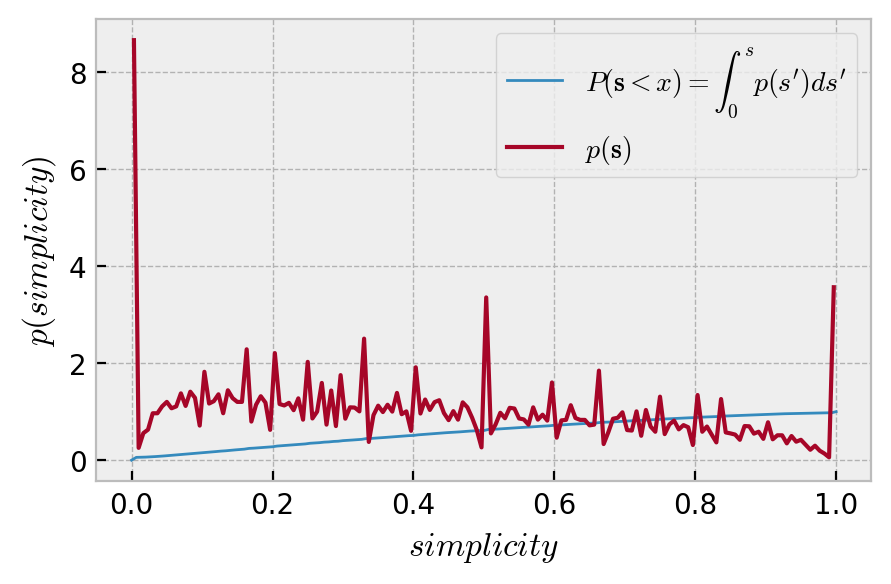

In [32]:
plt.figure(figsize=(5, 3))
plt.plot(HIST_EDGES, int_pnts, lw=1, label="$P(\mathbf{s}<x)=\int_0^s p(s')ds'$")
plt.plot(HIST_CENTERS, SIMPL_DENS_HIST,
         lw=1.5, label="$p(\mathbf{s})$")
plt.xlabel("$simplicity$")
plt.ylabel("$p(simplicity)$")
plt.legend();

**Интересно**, что выделяются (по кол-ву) вопросы, на которые ответили все, на которые никто не ответил и с которыми справилась только половина команд (внутри каждого турнира)!

Начем же уже предсказывать рейтинги игроков!

In [33]:
def player_rank(model):
    # predictions = p(answer|simplicity)
    predictions = model.predict_proba(HIST_CENTERS.reshape(-1, 1))[:, 1]
    return (predictions * SIMPL_DENS_HIST).sum() * BIN_SIZE # integrate

In [34]:
%%time
players_ranked = {"player_id": [], "rank": [], "answered": []}

for player_id in tqdm(P_vs_Q_train_df["player_id"].unique()):  # go through all unique players
    players_ranked["player_id"].append(player_id)
    
    player_data = P_vs_Q_train_df[P_vs_Q_train_df["player_id"] == player_id]
    player_answers = player_data["answer"].values
    
    players_ranked["answered"].append(len(player_answers))
    
    if player_answers.sum() == 0:
        players_ranked["rank"].append(0)
    else:
        # get simplicity of each question answered (or not) by the player with player_id
        player_q_simplicity = player_data["simplicity"].values.reshape(-1, 1)
        # solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
        logreg = LogisticRegression()
        # from questions simlicity predicting answers (0 or 1)
        logreg.fit(player_q_simplicity, player_answers)
        # calculate player rank!
        players_ranked["rank"].append(player_rank(logreg))

100%|████████████████████████████████████| 56865/56865 [08:21<00:00, 113.30it/s]

CPU times: user 24min 6s, sys: 29.9 s, total: 24min 36s
Wall time: 8min 21s


In [35]:
# result
players_ranked_df = pd.DataFrame({"answered": players_ranked["answered"], "rank": players_ranked["rank"]},
                                 index=players_ranked["player_id"])
players_ranked_df.head()

,answered,rank
6212,3306,0.695856
18332,3751,0.712763
18036,1457,0.709691
22799,2219,0.689353
15456,2322,0.669563


In [36]:
# saving results
players_ranked_path = "data/players_ranked.csv"
players_ranked_df.to_csv(players_ranked_path, index=True)

In [37]:
gc.collect()

18958

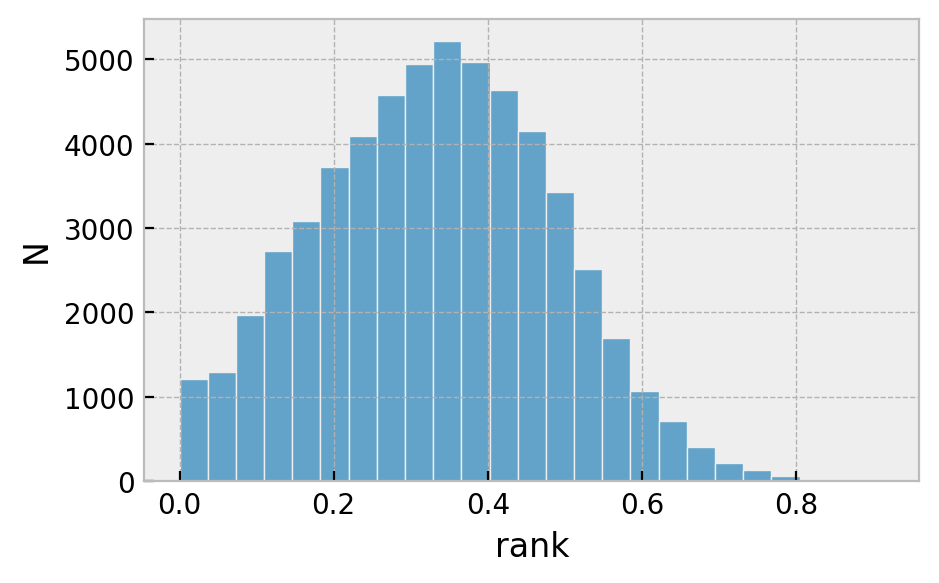

In [38]:
players_ranked_df = pd.read_csv(players_ranked_path, index_col=[0])
# histogram
plt.figure(figsize=(5, 3))
sns.histplot(players_ranked_df["rank"], bins=25)
plt.xlabel("rank")
plt.ylabel("N");

### Топ игроков

In [39]:
names_ranked_df = players_train_df.join(players_ranked_df, how="left")
names_ranked_df.sort_values(by="rank", ascending=False).head(10)

,id,name,patronymic,surname,answered,rank
121433,121433,София,Романовна,Савенко,36,0.914342
186002,186002,Инга,Андрисовна,Лоренц,36,0.903864
202410,202410,Валентина,,Подюкова,36,0.899327
216863,216863,Глеб,Юрьевич,Гаврилов,36,0.893846
133504,133504,София,Евгеньевна,Лебедева,36,0.893755
135951,135951,Артём,Феликсович,Стетой,36,0.893436
170977,170977,Давид,Сергеевич,Кан,36,0.891412
171845,171845,Михаил,Владимирович,Завьялов,36,0.891412
215497,215497,Екатерина,,Горелова,36,0.881921
215496,215496,Наталья,,Артемьева,36,0.881921


Топ возглавили игроки, которые сыграли очень мало вопросов! Это _не очень хороший_ топ.

Ограничимся в нашем _правильном_ топе теми игроками, которые ответили на достаточное кол-во вопросов (например на 500 и более, что соответствует $>10$ играм):

In [40]:
names_ranked_df.loc[names_ranked_df["answered"] >= 500].sort_values(by="rank", ascending=False).head(50)

,id,name,patronymic,surname,answered,rank
27403,27403,Максим,Михайлович,Руссо,2178,0.782318
4270,4270,Александра,Владимировна,Брутер,2692,0.775227
28751,28751,Иван,Николаевич,Семушин,3774,0.772662
27822,27822,Михаил,Владимирович,Савченков,3215,0.761132
30152,30152,Артём,Сергеевич,Сорожкин,4849,0.750640
30270,30270,Сергей,Леонидович,Спешков,3737,0.747716
87637,87637,Антон,Владимирович,Саксонов,1194,0.733565
4226,4226,Сусанна,Марковна,Бровер,600,0.720282
20691,20691,Станислав,Григорьевич,Мереминский,1584,0.718392
56647,56647,Наталья,Евгеньевна,Горелова,2093,0.716340


### Часть 3.

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров$^1$.

$^1$_**Для самопроверки**: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг._

Мы научились считать вероятность того, что игрок ответит на произвольный вопрос. Для оценки рейтинга команды напрашивается следующая величина: вероятность того, что хотя бы один член команды даст ответ на произвольный вопрос, т.е.
$$P(\text{team answers})=1-\prod_{\text{player}\in\text{team}} (1-P(\text{player answers}))$$

In [52]:
def eval_spearman_and_kendall(results, players_ranked_df):

    spearman, kendall = 0, 0
    counted_results = 0
    
    # predicting teams ranks
    for result in tqdm(results.values()):
        ranks = []  # for teams ranking
        for team in result:
            team_place = int(team["position"])
            team_rank = 1
            for player in team["teamMembers"]:
                player_id = player["player"]["id"]
                if player_id in players_ranked_df.index:
                    team_rank *= 1 - players_ranked_df["rank"][player_id]
            team_rank = 1 - team_rank
            ranks.append((team_rank, team_place))
        
        ranks.sort()  # sort by ranks

        actual = np.array(list(zip(*ranks))[1])  # places from data
        preds = np.arange(len(result) + 1, 1, -1)  # places predicted by teams ranks
        
        spearman_i = stats.spearmanr(actual, preds)[0]
        kendall_i = stats.kendalltau(actual, preds)[0]
        if not np.isnan(spearman_i) and not np.isnan(kendall_i):
            spearman += spearman_i
            kendall += kendall_i
            counted_results += 1
        
    # return average metrics
    return spearman / counted_results, kendall / counted_results

In [54]:
%%time
spearman_test, kendall_test = eval_spearman_and_kendall(R_test, players_ranked_df)
print(f"Spearman: {spearman_test}\nKendall: {kendall_test}", end='\n\n')

100%|████████████████████████████████████████| 660/660 [00:02<00:00, 225.66it/s]

Spearman: 0.7743781913470459
Kendall: 0.6183006734906765

CPU times: user 2.55 s, sys: 240 ms, total: 2.79 s
Wall time: 2.93 s


### Часть 4.

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные "игрок X ответил на вопрос Y" при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.